Predictive analytics helps us a lot on this one. One of the many opportunities it can provide is predicting the next purchase day of the customer. What if you know if a customer is likely to make another purchase in 7 days?   

We can build our strategy on top of that and come up with lots of tactical actions like:
No promotional offer to this customer since s/he will make a purchase anyways
Nudge the customer with inbound marketing if there is no purchase in the predicted time window (or fire the guy who did the prediction 🦹‍♀️ 🦹‍♂️ )


In [1]:
from __future__ import division
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.cluster import KMeans



In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [5]:
tx_data = pd.read_csv('./Downloads/data/OnlineRetail.csv',encoding= 'unicode_escape')
tx_data.shape

(541909, 8)

In [6]:
tx_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [7]:
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])
tx_data['InvoiceDate'].describe()

count                  541909
unique                  23260
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [10]:
tx_data['InvoiceDate'].describe()

count                  541909
unique                  23260
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [9]:
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)

We use six months of behavioral data to predict customers’ first purchase date in the next three months. If there is no purchase, we will predict that too. Let’s assume our cut off date is Sep 9th ’11 and split the data

In [11]:
tx_6m = tx_uk[(tx_uk.InvoiceDate < datetime(2011,9,1)) & (tx_uk.InvoiceDate >= datetime(2011,3,1))].reset_index(drop=True)

tx_6m represents the six months performance whereas tx_next for the find out the days between the last purchase date in tx_6m and the first one in tx_next.

In [12]:
tx_next = tx_uk[(tx_uk.InvoiceDate >= datetime(2011,9,1)) & (tx_uk.InvoiceDate < datetime(2011,12,1))].reset_index(drop=True)
tx_next['InvoiceDate'].describe()

count                  178694
unique                   6781
top       2011-10-31 14:41:00
freq                     1114
first     2011-09-01 08:25:00
last      2011-11-30 17:42:00
Name: InvoiceDate, dtype: object

In [13]:
tx_user = pd.DataFrame(tx_6m['CustomerID'].unique())
tx_user.columns = ['CustomerID']

# Adding label

In [15]:
tx_next_first_purchase = tx_next.groupby('CustomerID').InvoiceDate.min().reset_index()

In [16]:
tx_next_first_purchase.columns = ['CustomerID','MinPurchaseDate']

In [17]:
tx_next_first_purchase.head()

,CustomerID,MinPurchaseDate
0,12747.0,2011-10-04 08:26:00
1,12748.0,2011-09-02 10:49:00
2,12749.0,2011-11-17 12:05:00
3,12820.0,2011-09-26 11:49:00
4,12822.0,2011-09-13 13:46:00


In [18]:
tx_last_purchase = tx_6m.groupby('CustomerID').InvoiceDate.max().reset_index()

In [19]:
tx_last_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [20]:
tx_purchase_dates = pd.merge(tx_last_purchase,tx_next_first_purchase,on='CustomerID',how='left')

In [21]:
tx_purchase_dates['NextPurchaseDay'] = (tx_purchase_dates['MinPurchaseDate'] - tx_purchase_dates['MaxPurchaseDate']).dt.days



In [22]:
tx_purchase_dates.head()

,CustomerID,MaxPurchaseDate,MinPurchaseDate,NextPurchaseDay
0,12747.0,2011-08-22 10:38:00,2011-10-04 08:26:00,42.0
1,12748.0,2011-08-30 12:00:00,2011-09-02 10:49:00,2.0
2,12749.0,2011-08-18 06:19:00,2011-11-17 12:05:00,91.0
3,12821.0,2011-05-09 15:51:00,NaT,NaN
4,12823.0,2011-08-04 17:45:00,2011-09-26 07:35:00,52.0


In [23]:
tx_user = pd.merge(tx_user, tx_purchase_dates[['CustomerID','NextPurchaseDay']],on='CustomerID',how='left')

In [24]:
tx_user.head()

,CustomerID,NextPurchaseDay
0,14620.0,NaN
1,14740.0,NaN
2,13880.0,57.0
3,16462.0,111.0
4,17068.0,16.0


In [25]:
tx_user.shape

(2569, 2)

In [26]:
tx_user = tx_user.fillna(999)

# Recency

In [27]:
tx_max_purchase = tx_6m.groupby('CustomerID').InvoiceDate.max().reset_index()

In [28]:
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [29]:
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

In [30]:
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

In [31]:
tx_user.head()

,CustomerID,NextPurchaseDay,Recency
0,14620.0,999.0,104
1,14740.0,999.0,91
2,13880.0,57.0,45
3,16462.0,111.0,85
4,17068.0,16.0,10


In [32]:
tx_user.Recency.describe()

count    2568.000000
mean       66.724299
std        52.251492
min         0.000000
25%        20.750000
50%        55.000000
75%       104.000000
max       183.000000
Name: Recency, dtype: float64

In [33]:
plot_data = [
    go.Histogram(
        x=tx_user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

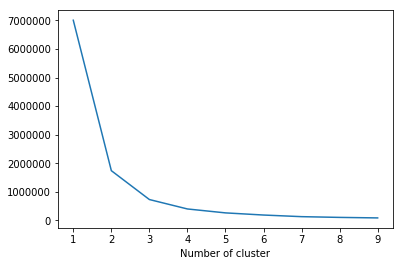

In [34]:
sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [35]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

In [36]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


In [37]:
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [38]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,449.0,154.665924,15.863669,126.0,141.0,154.0,167.0,183.0
1,573.0,97.125654,13.976688,75.0,85.0,98.0,110.0,125.0
2,665.0,50.935338,12.413812,33.0,40.0,49.0,62.0,73.0
3,881.0,14.049943,8.883066,0.0,7.0,13.0,21.0,31.0


# Frequency

In [39]:
tx_frequency = tx_6m.groupby('CustomerID').InvoiceDate.count().reset_index()

In [40]:
tx_frequency.columns = ['CustomerID','Frequency']

In [41]:
tx_frequency.head()

,CustomerID,Frequency
0,12747.0,50
1,12748.0,1210
2,12749.0,160
3,12821.0,6
4,12823.0,2


In [42]:
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

In [43]:
tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency
0,14620.0,999.0,104,1,30
1,14740.0,999.0,91,1,93
2,16462.0,111.0,85,1,2
3,15676.0,178.0,113,1,63
4,15092.0,999.0,115,1,26


In [44]:
tx_user.Frequency.describe()

count    2568.000000
mean       55.985981
std       109.245890
min         1.000000
25%        13.000000
50%        29.000000
75%        64.000000
max      3546.000000
Name: Frequency, dtype: float64

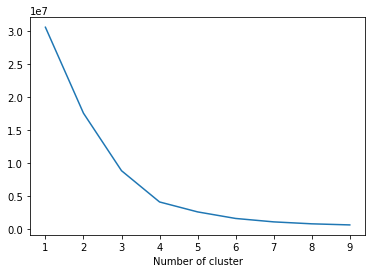

In [46]:
sse={}
tx_frequency = tx_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [47]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

In [48]:
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,2239.0,31.732023,26.036899,1.0,11.00,23.0,46.00,107.0
1,16.0,766.062500,260.797103,510.0,555.75,646.5,936.50,1251.0
2,1.0,3546.000000,NaN,3546.0,3546.00,3546.0,3546.00,3546.0
3,312.0,182.439103,70.488211,108.0,130.00,160.0,212.25,450.0


In [49]:
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

# Monetary Value

In [50]:
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']

In [51]:
tx_revenue = tx_6m.groupby('CustomerID').Revenue.sum().reset_index()

In [52]:
tx_revenue.head()

,CustomerID,Revenue
0,12747.0,1760.09
1,12748.0,8115.68
2,12749.0,2532.55
3,12821.0,92.72
4,12823.0,688.50


In [53]:
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

In [54]:
tx_user.Revenue.describe()

count     2568.000000
mean      1078.621843
std       3156.461431
min      -4287.630000
25%        222.967500
50%        440.130000
75%       1026.340000
max      88948.330000
Name: Revenue, dtype: float64

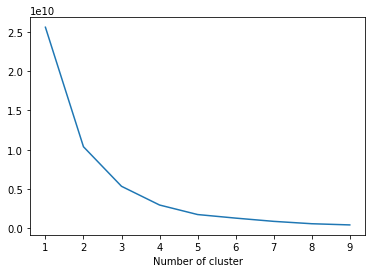

In [56]:
sse={}
tx_revenue = tx_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [57]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])

In [58]:
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

In [59]:
tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,2415.0,635.360862,618.311128,-4287.63,212.1850,406.480,866.6600,2906.31
1,136.0,5237.716699,2617.500448,2952.40,3282.0950,4419.950,5634.9350,13760.87
2,15.0,24656.247333,7716.951663,15847.56,17484.2400,23196.350,31386.6450,37934.22
3,2.0,76665.615000,17370.382136,64382.90,70524.2575,76665.615,82806.9725,88948.33


# Overall Segmentation

In [60]:
tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,14620.0,999.0,104,1,30,0,393.28,0
1,14740.0,999.0,91,1,93,0,1423.21,0
2,16462.0,111.0,85,1,2,0,68.00,0
3,15676.0,178.0,113,1,63,0,877.40,0
4,15092.0,999.0,115,1,26,0,457.81,0


In [61]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

In [62]:
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,154.750000,19.412162,289.172973
1,97.965766,27.293694,445.157207
2,52.656766,37.529703,576.943186
3,18.450808,52.588840,904.059517
4,15.445652,160.429348,2526.410000
5,9.815789,214.855263,6653.958947
6,8.812500,568.562500,13181.453125
7,12.200000,591.600000,46209.390000
8,3.000000,3546.000000,16643.220000


In [63]:
tx_user.groupby('OverallScore')['Recency'].count()

OverallScore
0    444
1    555
2    606
3    681
4    184
5     76
6     16
7      5
8      1
Name: Recency, dtype: int64

In [64]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [68]:
tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,14620.0,999.0,104,1,30,0,393.28,0,1,Low-Value
1,14740.0,999.0,91,1,93,0,1423.21,0,1,Low-Value
2,16462.0,111.0,85,1,2,0,68.00,0,1,Low-Value
3,15676.0,178.0,113,1,63,0,877.40,0,1,Low-Value
4,15092.0,999.0,115,1,26,0,457.81,0,1,Low-Value


# Adding new features

In [69]:
tx_6m.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,545220,21955,DOORMAT UNION JACK GUNS AND ROSES,2,2011-03-01 08:30:00,7.95,14620.0,United Kingdom,15.90
1,545220,48194,DOORMAT HEARTS,2,2011-03-01 08:30:00,7.95,14620.0,United Kingdom,15.90
2,545220,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-03-01 08:30:00,1.65,14620.0,United Kingdom,19.80
3,545220,22139,RETROSPOT TEA SET CERAMIC 11 PC,3,2011-03-01 08:30:00,4.95,14620.0,United Kingdom,14.85
4,545220,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,2011-03-01 08:30:00,3.75,14620.0,United Kingdom,15.00


In [70]:
#create a dataframe with CustomerID and Invoice Date
tx_day_order = tx_6m[['CustomerID','InvoiceDate']]

In [71]:
#Convert Invoice Datetime to day
tx_day_order['InvoiceDay'] = tx_6m['InvoiceDate'].dt.date

In [72]:
tx_day_order = tx_day_order.sort_values(['CustomerID','InvoiceDate'])

In [73]:
#Drop duplicates
tx_day_order = tx_day_order.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')

In [74]:
#shifting last 3 purchase dates
tx_day_order['PrevInvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(1)
tx_day_order['T2InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(2)
tx_day_order['T3InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(3)

In [75]:
tx_day_order.head()

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate
649,12747.0,2011-03-01 14:53:00,2011-03-01,NaN,NaN,NaN
65091,12747.0,2011-05-05 15:31:00,2011-05-05,2011-03-01,NaN,NaN
90473,12747.0,2011-05-25 09:57:00,2011-05-25,2011-05-05,2011-03-01,NaN
124699,12747.0,2011-06-28 10:06:00,2011-06-28,2011-05-25,2011-05-05,2011-03-01
184410,12747.0,2011-08-22 10:38:00,2011-08-22,2011-06-28,2011-05-25,2011-05-05


In [76]:
tx_day_order['DayDiff'] = (tx_day_order['InvoiceDay'] - tx_day_order['PrevInvoiceDate']).dt.days
tx_day_order['DayDiff2'] = (tx_day_order['InvoiceDay'] - tx_day_order['T2InvoiceDate']).dt.days
tx_day_order['DayDiff3'] = (tx_day_order['InvoiceDay'] - tx_day_order['T3InvoiceDate']).dt.days

In [77]:
tx_day_order.head(10)

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
649,12747.0,2011-03-01 14:53:00,2011-03-01,NaN,NaN,NaN,NaN,NaN,NaN
65091,12747.0,2011-05-05 15:31:00,2011-05-05,2011-03-01,NaN,NaN,65.0,NaN,NaN
90473,12747.0,2011-05-25 09:57:00,2011-05-25,2011-05-05,2011-03-01,NaN,20.0,85.0,NaN
124699,12747.0,2011-06-28 10:06:00,2011-06-28,2011-05-25,2011-05-05,2011-03-01,34.0,54.0,119.0
184410,12747.0,2011-08-22 10:38:00,2011-08-22,2011-06-28,2011-05-25,2011-05-05,55.0,89.0,109.0
7326,12748.0,2011-03-08 12:30:00,2011-03-08,NaN,NaN,NaN,NaN,NaN,NaN
10606,12748.0,2011-03-11 11:37:00,2011-03-11,2011-03-08,NaN,NaN,3.0,NaN,NaN
17545,12748.0,2011-03-18 13:08:00,2011-03-18,2011-03-11,2011-03-08,NaN,7.0,10.0,NaN
20123,12748.0,2011-03-21 15:40:00,2011-03-21,2011-03-18,2011-03-11,2011-03-08,3.0,10.0,13.0
24764,12748.0,2011-03-24 13:37:00,2011-03-24,2011-03-21,2011-03-18,2011-03-11,3.0,6.0,13.0


In [78]:
tx_day_diff = tx_day_order.groupby('CustomerID').agg({'DayDiff': ['mean','std']}).reset_index()



In [79]:
tx_day_diff.columns = ['CustomerID', 'DayDiffMean','DayDiffStd']

In [80]:
tx_day_diff.head()

,CustomerID,DayDiffMean,DayDiffStd
0,12747.0,43.500000,20.305993
1,12748.0,3.723404,3.083632
2,12749.0,25.000000,30.099834
3,12821.0,NaN,NaN
4,12823.0,127.000000,NaN


In [81]:
tx_day_order_last = tx_day_order.drop_duplicates(subset=['CustomerID'],keep='last')

In [82]:
tx_day_order_last.head(10)

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
184410,12747.0,2011-08-22 10:38:00,2011-08-22,2011-06-28,2011-05-25,2011-05-05,55.0,89.0,109.0
192527,12748.0,2011-08-30 12:00:00,2011-08-30,2011-08-25,2011-08-24,2011-08-17,5.0,6.0,13.0
181411,12749.0,2011-08-18 06:19:00,2011-08-18,2011-08-11,2011-08-01,2011-05-23,7.0,17.0,87.0
70339,12821.0,2011-05-09 15:51:00,2011-05-09,NaN,NaN,NaN,NaN,NaN,NaN
169417,12823.0,2011-08-04 17:45:00,2011-08-04,2011-03-30,NaN,NaN,127.0,NaN,NaN
122212,12826.0,2011-06-24 11:47:00,2011-06-24,2011-06-14,NaN,NaN,10.0,NaN,NaN
182629,12828.0,2011-08-19 09:23:00,2011-08-19,2011-08-01,NaN,NaN,18.0,NaN,NaN
162086,12830.0,2011-07-28 17:17:00,2011-07-28,2011-07-21,2011-07-06,2011-06-21,7.0,22.0,37.0
21424,12831.0,2011-03-22 13:02:00,2011-03-22,NaN,NaN,NaN,NaN,NaN,NaN
147556,12833.0,2011-07-17 13:46:00,2011-07-17,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
tx_day_order_last = tx_day_order_last.dropna()

In [84]:
tx_day_order_last = pd.merge(tx_day_order_last, tx_day_diff, on='CustomerID')

In [85]:
tx_user = pd.merge(tx_user, tx_day_order_last[['CustomerID','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='CustomerID')


In [86]:
tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
0,14740.0,999.0,91,1,93,0,1423.21,0,1,Low-Value,6.0,34.0,92.0,30.666667,26.102363
1,17770.0,999.0,98,1,38,0,1143.27,0,1,Low-Value,14.0,77.0,84.0,28.000000,30.512293
2,15643.0,999.0,79,1,36,0,647.40,0,1,Low-Value,5.0,6.0,12.0,25.750000,43.553607
3,14231.0,999.0,79,1,35,0,513.11,0,1,Low-Value,4.0,53.0,103.0,34.333333,26.274195
4,18218.0,999.0,106,1,24,0,626.38,0,1,Low-Value,5.0,61.0,75.0,25.000000,27.221315


In [87]:
len(tx_user)

623

# Grouping the label

In [131]:
tx_class = tx_user.copy()

In [132]:
tx_class = pd.get_dummies(tx_class)

In [134]:
tx_class.tail(10)

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,NextPurchaseDayRange,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
613,16029.0,12.0,7,3,127,1,17081.82,2,6,6.0,7.0,19.0,7.318182,5.276961,2,1,0,0
614,17511.0,21.0,14,3,450,1,37661.72,2,6,9.0,13.0,28.0,9.625000,7.940403,1,1,0,0
615,14680.0,26.0,21,3,145,1,15847.56,2,6,14.0,33.0,57.0,19.142857,10.976165,1,1,0,0
616,14088.0,74.0,28,3,203,1,17886.66,2,6,7.0,15.0,21.0,12.400000,7.436397,0,1,0,0
617,15311.0,13.0,12,3,1061,2,31277.65,2,7,1.0,4.0,9.0,4.750000,3.417392,2,1,0,0
618,13089.0,0.0,0,3,895,2,22670.13,2,7,6.0,9.0,12.0,4.214286,3.008409,2,1,0,0
619,14298.0,23.0,23,3,750,2,23767.94,2,7,18.0,42.0,67.0,14.400000,10.297788,1,1,0,0
620,17841.0,3.0,3,3,3546,3,16643.22,2,8,3.0,5.0,9.0,3.423077,1.318736,2,1,0,0
621,18102.0,27.0,26,3,136,1,88948.33,3,7,8.0,16.0,32.0,12.916667,9.718383,1,1,0,0
622,17450.0,1.0,0,3,116,1,64382.90,3,7,8.0,14.0,34.0,11.666667,8.820971,2,1,0,0


In [135]:
tx_user.NextPurchaseDay.describe()

count    623.000000
mean     176.390048
std      326.482713
min        0.000000
25%       24.500000
50%       47.000000
75%       87.000000
max      999.000000
Name: NextPurchaseDay, dtype: float64

In [141]:
tx_class['NextPurchaseDayRange'] = 2
tx_class.loc[tx_class.NextPurchaseDay>20,'NextPurchaseDayRange'] = 1
tx_class.loc[tx_class.NextPurchaseDay>50,'NextPurchaseDayRange'] = 0


In [140]:
tx_class.NextPurchaseDayRange.value_counts()/len(tx_user)

0    0.475120
1    0.325843
2    0.199037
Name: NextPurchaseDayRange, dtype: float64

In [138]:
#tx_class = tx_class[tx_class.Frequency>10]

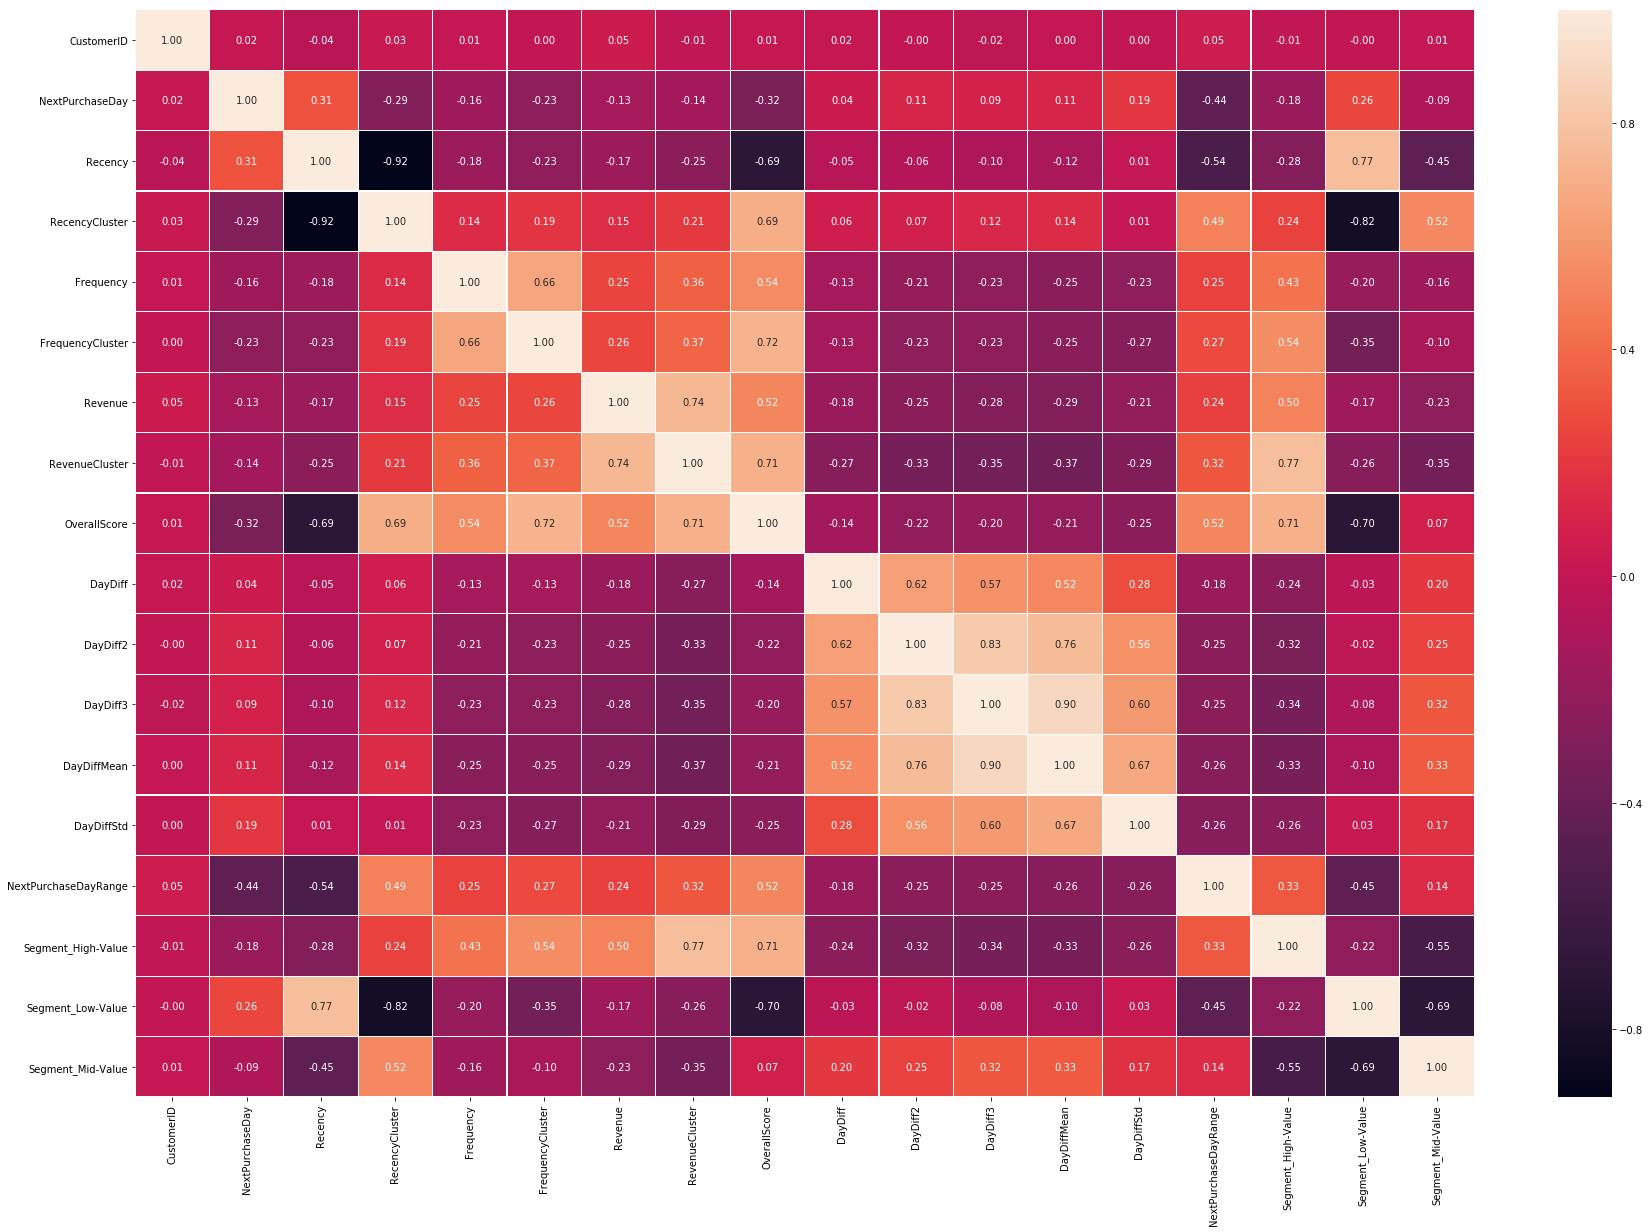

In [139]:
corr = tx_class[tx_class.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

In [119]:
tx_class = tx_class.drop('NextPurchaseDay',axis=1)

In [120]:
len(tx_class)

623

In [121]:
X, y = tx_class.drop('NextPurchaseDayRange',axis=1), tx_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [122]:
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))


In [123]:
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

('LR', array([0.59839357, 0.60240964]))
('NB', array([0.64257028, 0.64658635]))
('RF', array([0.61044177, 0.6064257 ]))
('SVC', array([0.4939759 , 0.47389558]))
('Dtree', array([0.51004016, 0.55823293]))
('XGB', array([0.57429719, 0.58232932]))
('KNN', array([0.4939759 , 0.48995984]))


In [124]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))



Accuracy of XGB classifier on training set: 0.93
Accuracy of XGB classifier on test set: 0.58


In [125]:
y_pred = xgb_model.predict(X_test)

In [126]:
print classification_report(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.63      0.73      0.68        55
           1       0.57      0.42      0.48        50
           2       0.48      0.60      0.53        20

   micro avg       0.58      0.58      0.58       125
   macro avg       0.56      0.58      0.56       125
weighted avg       0.58      0.58      0.58       125



In [127]:
from sklearn.model_selection import GridSearchCV

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(), 
param_grid = param_test1, scoring='accuracy',n_jobs=-1,iid=False, cv=2)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 5}, 0.6124516129032258)

In [128]:
xgb_model = xgb.XGBClassifier(max_depth=3, min_child_weight=5).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))



Accuracy of XGB classifier on training set: 0.92
Accuracy of XGB classifier on test set: 0.62


In [129]:
y_pred = xgb_model.predict(X_test)

In [130]:
print classification_report(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.66      0.71      0.68        55
           1       0.64      0.54      0.59        50
           2       0.50      0.60      0.55        20

   micro avg       0.62      0.62      0.62       125
   macro avg       0.60      0.62      0.61       125
weighted avg       0.63      0.62      0.62       125

